In [1]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

In [2]:
medianblur_design = Overlay("medianblur.bit")

In [3]:
for i in medianblur_design.ip_dict:
    print(i)

median_blur_accel_0
axi_dma_0
processing_system7_0


In [5]:
dma = medianblur_design.axi_dma_0
medianblur = medianblur_design.median_blur_accel_0

In [6]:
image_path = "/home/xilinx/jupyter_notebooks/images/Emir_Abdelkader_4K_Noisy.jpg"
original_image = Image.open(image_path)

Image size: 3840x2160 pixels.


<Figure size 864x576 with 0 Axes>

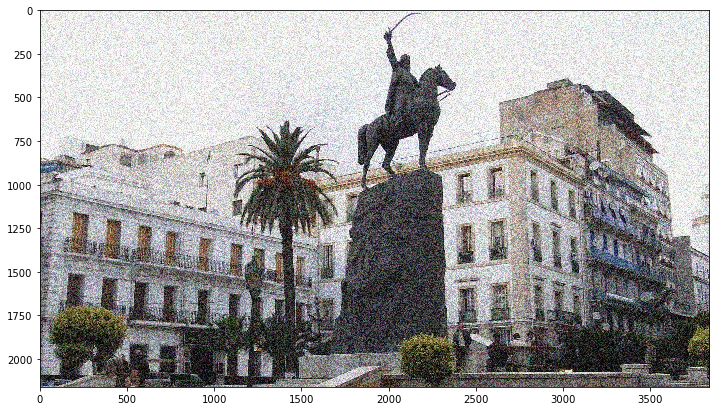

In [7]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)

width, height = original_image.size
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(original_image)

In [8]:
in_buffer = allocate(shape=(height, width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(height, width, 3),
                           dtype=np.uint8, cacheable=1)

In [9]:
in_buffer[:] = np.array(original_image)

In [10]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    medianblur.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [12]:
#bilateral.register_map.sigma_color = 200
#bilateral.register_map.sigma_space = 50
medianblur.register_map.rows = height
medianblur.register_map.cols = width

In [13]:
run_kernel()
medianblur_image = Image.fromarray(out_buffer)

Image size: 3840x2160 pixels.


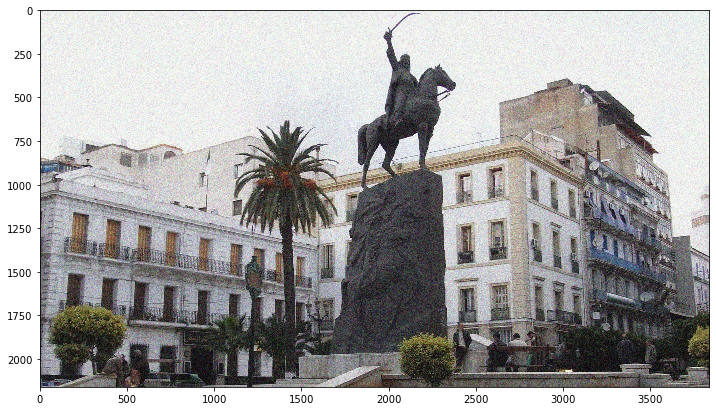

In [14]:
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(medianblur_image)

In [15]:
medianblur_image.save('Emirmedianblur.png')

In [16]:
%%timeit
run_kernel()
medianblur_image = Image.fromarray(out_buffer)

405 ms ± 476 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
del in_buffer
del out_buffer

Image size: 3840x2160 pixels.


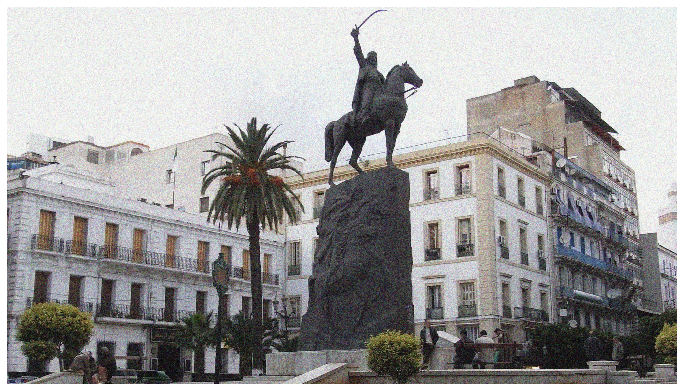

In [18]:
original_image2 = cv2.imread("/home/xilinx/jupyter_notebooks/images/Emir_Abdelkader_4K_Noisy.jpg")
original_image2 = cv2.cvtColor(original_image2, cv2.COLOR_BGR2RGB)
median = cv2.medianBlur(original_image2,3)
height, width, channels =median.shape
print("Image size: {}x{} pixels.".format(width, height))

plt.figure(figsize=(12, 10));
plt.axis("off")
_ =plt.imshow(median)

In [19]:
%%timeit
median = cv2.medianBlur(original_image2,3)

5.83 s ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
